<a href="https://colab.research.google.com/github/rabimba/GDE-ML-Artifacts/blob/main/Arxiv_Reader.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup

In [ ]:
!pip install -Uq google-generativeai

In [ ]:
import google.generativeai as genai


import pathlib
import tqdm
import os

In [ ]:
from google.colab import userdata
genai.configure(api_key=userdata.get("GOOGLE_API_KEY"))

Install the PDF processing tools:

In [ ]:
!apt install poppler-utils

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
poppler-utils is already the newest version (22.02.0-2ubuntu0.3).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


## Download and proces the PDF

This is a research paper available in Arxiv.

In [ ]:
import pathlib

In [ ]:
if not pathlib.Path('test.pdf').exists():
    !curl -o test.pdf https://arxiv.org/pdf/2308.01474

You'll extract pages 1-9

In [ ]:
first = 1
last = 9

In [ ]:
!rm -rf output/
!mkdir output
! # extract images of Chapter 3
!pdftoppm test.pdf -f {first} -l {last} output/images -jpeg
!ls output

images-1.jpg  images-2.jpg  images-3.jpg  images-4.jpg	images-5.jpg  images-6.jpg  images-7.jpg


Look at the first image, scaled down:

In [ ]:
import PIL.Image

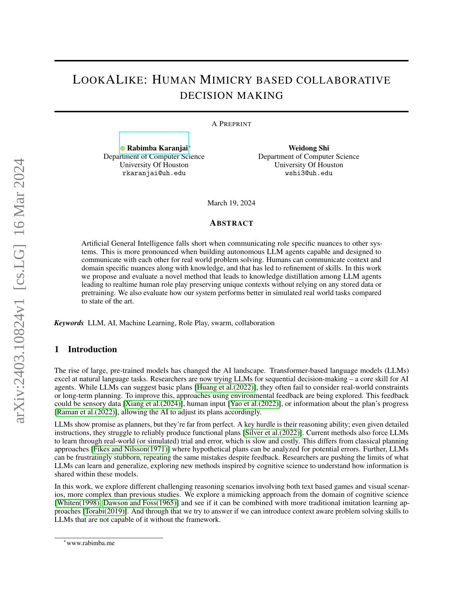

In [ ]:
img = PIL.Image.open(f"output/images-{first}.jpg")
img.thumbnail([600, 600])
img

Extract the text for thopse same pages.

In [ ]:
for page_number in range(first,last+1):
  page_number = f"{page_number:03d}"
  ! pdftotext  test.pdf -f {page_number} -l {page_number}
  ! mv test.txt output/text-{page_number}.txt

Command Line Error: Wrong page range given: the first page (8) can not be after the last page (7).
mv: cannot stat 'test.txt': No such file or directory
Command Line Error: Wrong page range given: the first page (9) can not be after the last page (7).
mv: cannot stat 'test.txt': No such file or directory


In [ ]:
!ls output

images-1.jpg  images-3.jpg  images-5.jpg  images-7.jpg	text-002.txt  text-004.txt  text-006.txt
images-2.jpg  images-4.jpg  images-6.jpg  text-001.txt	text-003.txt  text-005.txt  text-007.txt


In [ ]:
!cat output/text-00{first}.txt

L OOK AL IKE : H UMAN M IMICRY BASED COLLABORATIVE
DECISION MAKING

arXiv:2403.10824v1 [cs.LG] 16 Mar 2024

A P REPRINT
Rabimba Karanjai∗
Department of Computer Science
University Of Houston
rkaranjai@uh.edu

Weidong Shi
Department of Computer Science
University Of Houston
wshi3@uh.edu

March 19, 2024

A BSTRACT
Artificial General Intelligence falls short when communicating role specific nuances to other systems. This is more pronounced when building autonomous LLM agents capable and designed to
communicate with each other for real world problem solving. Humans can communicate context and
domain specific nuances along with knowledge, and that has led to refinement of skills. In this work
we propose and evaluate a novel method that leads to knowledge distillation among LLM agents
leading to realtime human role play preserving unique contexts without relying on any stored data or
pretraining. We also evaluate how our system performs better in simulated real world tasks compared
to state 

## Assemble the files into a prompt

Upload all the files usng the files API, there are too many to send with the `generate_content` request.

In [ ]:
files = []
image_files = list(pathlib.Path("output").glob('images-*.jpg'))
for img in tqdm.tqdm(image_files):
    files.append(genai.upload_file(img))

100%|██████████| 7/7 [00:06<00:00,  1.15it/s]


Load all the texts:

In [ ]:
texts = [t.read_text() for t in pathlib.Path("output").glob('text-*.txt')]

Interleave the page-numbers, texts, and image-file references:

In [ ]:
textbook = []
for page, (text, image) in enumerate(zip(texts, files)):
  textbook.append(f'## Page {first+page} ##')
  textbook.append(text)
  textbook.append(image)

## Try it out

In [ ]:
model = genai.GenerativeModel(model_name='gemini-1.5-pro-latest')

In [ ]:
response = model.generate_content(
    ['# Here is a Research paper:']+
    textbook +
    ["[END]\n\nPlease sumarize it"]
)

In [ ]:
from IPython.display import Markdown
Markdown(response.text)

## LookALike: Human Mimicry for Collaborative Decision Making: A Summary

This research paper introduces a novel method for improving the planning and problem-solving capabilities of Large Language Models (LLMs) through human mimicry and collaborative decision making. The approach aims to address the limitations of LLMs in reasoning and handling complex tasks by incorporating the following key elements:

**1. Collaborative Swarm of pLLMs:**
* Multiple player LLMs (pLLMs) work together, each assuming a different role in the task.
* They share information and learn from each other's successes and failures through a "memory" mechanism.

**2. Domain Expert vLLM:**
* A separate LLM (vLLM), trained on human expert demonstrations, acts as a domain expert.
* It provides feedback and rewards to the pLLMs based on their actions, guiding them towards optimal solutions.
* For visual tasks, vLLM also processes and interprets visual information. 

**3. Human Mimicry and Observational Learning:**
* pLLMs learn by observing and mimicking the successful behaviors of the vLLM and other pLLMs.
* This allows them to acquire domain-specific knowledge and context without relying solely on pre-training data.

**Evaluation:**

The researchers tested their approach on two tasks: playing the text-based game Zork and solving challenges in the Procgen environment, which involves visual scenarios. The results show significant improvements in success rates compared to using pLLMs alone. 

**Key Findings:**

* The collaborative swarm approach enables knowledge distillation among LLMs, leading to better performance on complex tasks.
*  Human mimicry and observational learning are effective methods for LLMs to acquire domain-specific knowledge and context. 
*  The framework demonstrates the potential for LLMs to learn and adapt in real-time without relying on extensive pre-training or stored data.

**Future Work:**

The paper suggests exploring the scalability of the approach to more complex tasks and environments. Additionally, incorporating messy perception and real-world constraints are areas for further investigation.

**Overall, this research presents a promising direction for developing more efficient and adaptable LLMs for real-world problem solving by leveraging human mimicry and collaborative learning.** 
